In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
pip install tensorflow


In [ ]:
import numpy as np
import pandas as pd

import os

if False:
    for dirname, _, filenames in os.walk('/kaggle/input'):
        for filename in filenames:
            print(os.path.join(dirname, filename))

In [6]:
import os
import re
import glob
import pathlib
import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import cv2

import PIL
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

from collections import Counter

from warnings import filterwarnings
filterwarnings('ignore')

SEED=123
np.random.seed(SEED)

In [7]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.layers import Dropout, BatchNormalization
from tensorflow.keras.layers import (
    Input, Dense, Conv2D, Flatten, Activation, 
    MaxPooling2D, AveragePooling2D, ZeroPadding2D, GlobalAveragePooling2D, GlobalMaxPooling2D, add
)

from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.applications.inception_v3 import InceptionV3

In [8]:
CFG = dict(
    batch_size        =  8,  # 8; 16; 32; 64; bigger batch size => moemry allocation issue
    epochs            =  10, # 5; 10; 20;
    verbose           =   1,  # 0; 1
    
    optimizer         = 'adam', # 'SGD', 'RMSprop'
     
    RANDOM_STATE      =  123,   
    
    # Images sizes
    img_size          = 224, 
    img_height        = 224, 
    img_width         = 224, 
    
    # Images augs
    ROTATION          = 180.0,
    ZOOM              =  10.0,
    ZOOM_RANGE        =  [0.9,1.1],
    HZOOM             =  10.0,
    WZOOM             =  10.0,
    HSHIFT            =  10.0,
    WSHIFT            =  10.0,
    SHEAR             =   5.0,
    HFLIP             = True,
    VFLIP             = True,
    
    # Postprocessing
    label_smooth_fac  =  0.05, # 0.01; 0.05; 0.1; 0.2;
    
)

In [9]:
BASEPATH = "../input/siim-isic-melanoma-classification"
df_train_full = pd.read_csv(os.path.join(BASEPATH, 'train.csv'))
df_test  = pd.read_csv(os.path.join(BASEPATH, 'test.csv'))
df_sub   = pd.read_csv(os.path.join(BASEPATH, 'sample_submission.csv'))

FileNotFoundError: ignored

In [12]:
from google.colab import drive

In [13]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [24]:
train_path='gdrive/My Drive/Train/'

In [15]:
test_path='gdrive/My Drive/Test/'

In [25]:
train_dir=pathlib.Path(train_path)

In [17]:
test_dir=pathlib.Path(test_path)

In [18]:
classes=[
    'pigmented benign keratosis',
    'melanoma',
    'vascular lesion',
    'actinic keratosis',
    'squamous cell carcinoma',
    'basal cell carcinoma',
    'seborrheic keratosis',
    'dermatofibroma',
    'nevus'
]

In [20]:
#EDA


FileNotFoundError: ignored

In [26]:
img_count_train = len(list(train_dir.glob('*/*.jpg')))
img_count_test  = len(list(test_dir.glob('*/*.jpg')))
print('{} train images'.format(img_count_train))
print('{} test  images'.format(img_count_test))

2239 train images
118 test  images


Found 2239 files belonging to 9 classes.
Using 1568 files for training.
Found 2239 files belonging to 9 classes.
Using 671 files for validation.
Found 118 files belonging to 9 classes.

9 classes:
['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


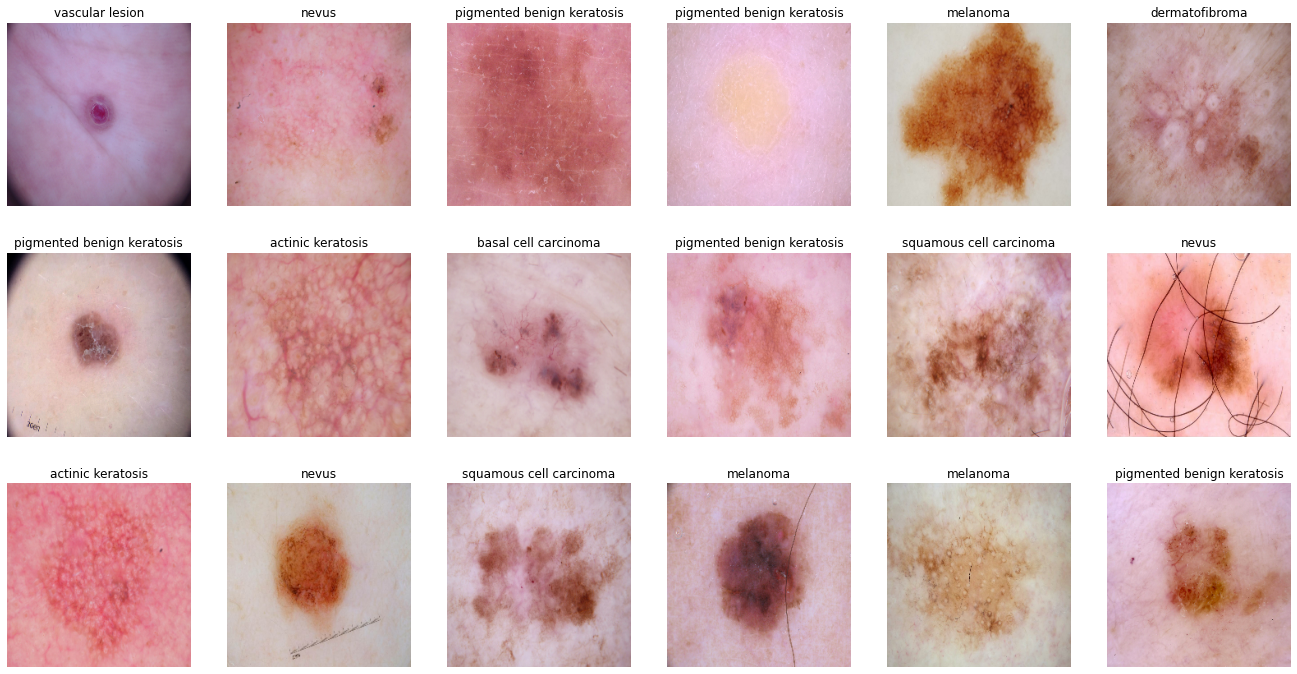

In [27]:
# We can read train and validation sets from same directory using Keras.

train_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.3, image_size=(224,224), subset="training", seed=SEED)
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(train_dir, validation_split=0.3, image_size=(224,224), subset="validation",seed=SEED)
test_ds  = tf.keras.preprocessing.image_dataset_from_directory(test_dir, image_size=(224,224), seed=SEED)

class_names = train_ds.class_names
num_classes = len(class_names)
print('\n{} classes:\n{}'.format(num_classes,class_names))

plt.figure(figsize=(23, 12))
for images, labels in train_ds.take(1):
    for i in range(18):
        ax = plt.subplot(3, 6, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

In [28]:
#Keras Image Data Processing

In [29]:
train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.3,
    rotation_range            = CFG['ROTATION'],
    zoom_range                = CFG['ZOOM_RANGE'],
    horizontal_flip           = CFG['HFLIP'],
    vertical_flip             = CFG['VFLIP'],
    height_shift_range        = CFG['HSHIFT'],
    width_shift_range         = CFG['WSHIFT'],
    shear_range               = CFG['SHEAR'],
    channel_shift_range       = 0.0,
    brightness_range          = None,
    fill_mode                 = 'nearest',                          
    )

valid_generator = ImageDataGenerator(rescale=1./255, validation_split=0.3)              # no aug for valid
test_generator  = ImageDataGenerator(rescale=1./255)                                    # no aug for test


# Train data
train_generator = train_datagen.flow_from_directory(train_dir,
                                                    subset='training',                  # to read train/valid from same directory 
                                                    target_size=(CFG['img_size'], CFG['img_size']),
                                                    batch_size = CFG['batch_size'],
                                                    class_mode='categorical',
                                                    )

# Validation data
valid_generator = valid_generator.flow_from_directory(train_dir,
                                                     subset='validation',               # to read train/valid from same directory 
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = CFG['batch_size'],
                                                     class_mode='categorical'
                                                     ) 
# Test data
test_generator  = test_generator.flow_from_directory(test_dir,
                                                     target_size=(CFG['img_size'], CFG['img_size']),
                                                     batch_size = 1,                    # using 1 to easily manage mapping between test_gen & pred
                                                     class_mode='categorical'
                                                     )

Found 1571 images belonging to 9 classes.
Found 668 images belonging to 9 classes.
Found 118 images belonging to 9 classes.


In [30]:
#Class weights

In [31]:
class_weights = class_weight.compute_class_weight('balanced',
                                                  np.unique(train_generator.classes), 
                                                  train_generator.classes) 

unique_class_weights = np.unique(train_generator.classes)
class_weights_dict   = { unique_class_weights[i]: w for i,w in enumerate(class_weights) }

print('\nCLASS WEIGHTS: {}\n'.format(class_weights))
print(np.unique(train_generator.classes))
print(train_generator.classes)
print(unique_class_weights)
print(Counter(train_generator.classes).keys()) 
print(Counter(train_generator.classes).values())


CLASS WEIGHTS: [2.18194444 0.66119529 2.6053068  0.56858487 0.69822222 0.53875171
 3.23251029 1.37445319 1.78117914]

[0 1 2 3 4 5 6 7 8]
[0 0 0 ... 8 8 8]
[0 1 2 3 4 5 6 7 8]
dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8])
dict_values([80, 264, 67, 307, 250, 324, 54, 127, 98])


In [32]:
model_ResNet50 = tf.keras.Sequential([
     tf.keras.applications.ResNet50(
        input_shape=(224, 224, 3),
        weights='imagenet',
        include_top=False
    ),
    
    GlobalAveragePooling2D(),
    
    #Dense(1024, activation = 'relu'), 
    #Dropout(0.5), 
    #BatchNormalization(),
    
    #Dense(256, activation='relu'), 
    #Dropout(0.3), 
    #BatchNormalization(),
    
    #Dense(64, activation='relu'), 
    #Dropout(0.2), 
    #BatchNormalization(),
    
    Dense(num_classes, activation='softmax') # num classes = 9
    
])
    
model_ResNet50.compile(
    optimizer = CFG['optimizer'],
    loss = tf.keras.losses.BinaryCrossentropy(label_smoothing = CFG['label_smooth_fac']),
    #loss = 'binary_crossentropy',
    metrics=['accuracy']
)

94773248/94765736 [==============================] - 1s 0us/step


In [33]:
from keras import backend as K

def focal_loss(alpha=0.20,gamma=2.0):
    def focal_crossentropy(y_true, y_pred):
        bce = K.binary_crossentropy(y_true, y_pred)
        
        y_pred = K.clip(y_pred, K.epsilon(), 1.- K.epsilon())
        p_t = (y_true*y_pred) + ((1-y_true)*(1-y_pred))
        
        alpha_factor = 1
        modulating_factor = 1

        alpha_factor = y_true*alpha + ((1-alpha)*(1-y_true))
        modulating_factor = K.pow((1-p_t), gamma)

        # compute the final loss and return
        return K.mean(alpha_factor*modulating_factor*bce, axis=-1)
    
    return focal_crossentropy


In [35]:
#Visualize the model

In [36]:
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 23,606,153
Trainable params: 23,553,033
Non-trainable params: 53,120
_________________________________________________________________


In [37]:
model_ResNet50.layers[0].trainable = False
#for layer in model_ResNet50.layers[:1]:
#    layer.trainable = False
model_ResNet50.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Functional)        (None, 7, 7, 2048)        23587712  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 9)                 18441     
Total params: 23,606,153
Trainable params: 18,441
Non-trainable params: 23,587,712
_________________________________________________________________


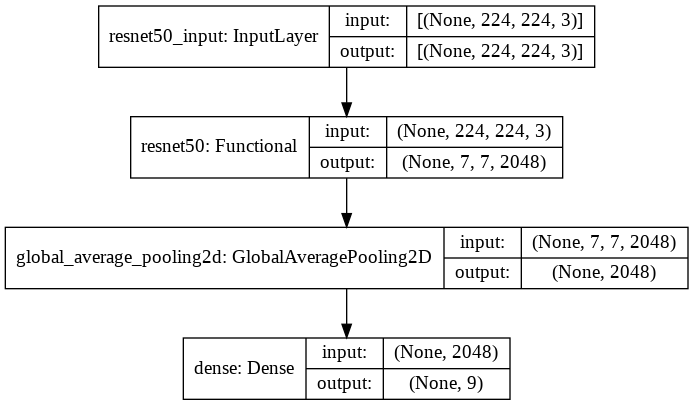

In [38]:
plot_model(model_ResNet50, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [39]:
#Fit MOdel


In [45]:
path_model = '../working/'

EPOCHS  = 10
WORKERS = 4

#tf.function-decorated function tried to create variables on non-first call'. 
tf.config.run_functions_eagerly(True) # otherwise error

# https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint
cb_early_stopper = EarlyStopping(monitor = 'val_loss', patience = 10)
cb_checkpointer  = ModelCheckpoint(#filepath=path_model, 
                                   filepath='../working/ResNet50-{epoch:02d}-{val_loss:.2f}.hdf5',
                                   monitor='val_loss', 
                                   verbose=1, 
                                   save_best_only=True, 
                                   mode='min'
                                  )

callbacks_list = [cb_checkpointer, cb_early_stopper]

history = model_ResNet50.fit(train_generator, 
                             epochs=EPOCHS, 
                             workers=WORKERS,
                             #steps_per_epoch = train_generator.n // 2, # hide if you wish
                             validation_data=valid_generator, 
                             #validation_steps=valid_generator.n // 2,  # hide if you wish
                             callbacks = callbacks_list,
                             class_weight = class_weights_dict
                            )

Epoch 1/10
197/197 [==============================] - 978s 5s/step - loss: 0.3397 - accuracy: 0.3335 - val_loss: 0.6936 - val_accuracy: 0.0614

Epoch 00001: val_loss improved from inf to 0.69365, saving model to ../working/ResNet50-01-0.69.hdf5
Epoch 2/10
197/197 [==============================] - 888s 4s/step - loss: 0.3354 - accuracy: 0.3673 - val_loss: 0.5386 - val_accuracy: 0.0629

Epoch 00002: val_loss improved from 0.69365 to 0.53860, saving model to ../working/ResNet50-02-0.54.hdf5
Epoch 3/10
197/197 [==============================] - 843s 4s/step - loss: 0.3293 - accuracy: 0.3889 - val_loss: 0.4115 - val_accuracy: 0.2051

Epoch 00003: val_loss improved from 0.53860 to 0.41148, saving model to ../working/ResNet50-03-0.41.hdf5
Epoch 4/10
197/197 [==============================] - 865s 4s/step - loss: 0.3257 - accuracy: 0.4055 - val_loss: 0.3380 - val_accuracy: 0.3787

Epoch 00004: val_loss improved from 0.41148 to 0.33802, saving model to ../working/ResNet50-04-0.34.hdf5
Epoch 5/

In [41]:
#Visualize Performance

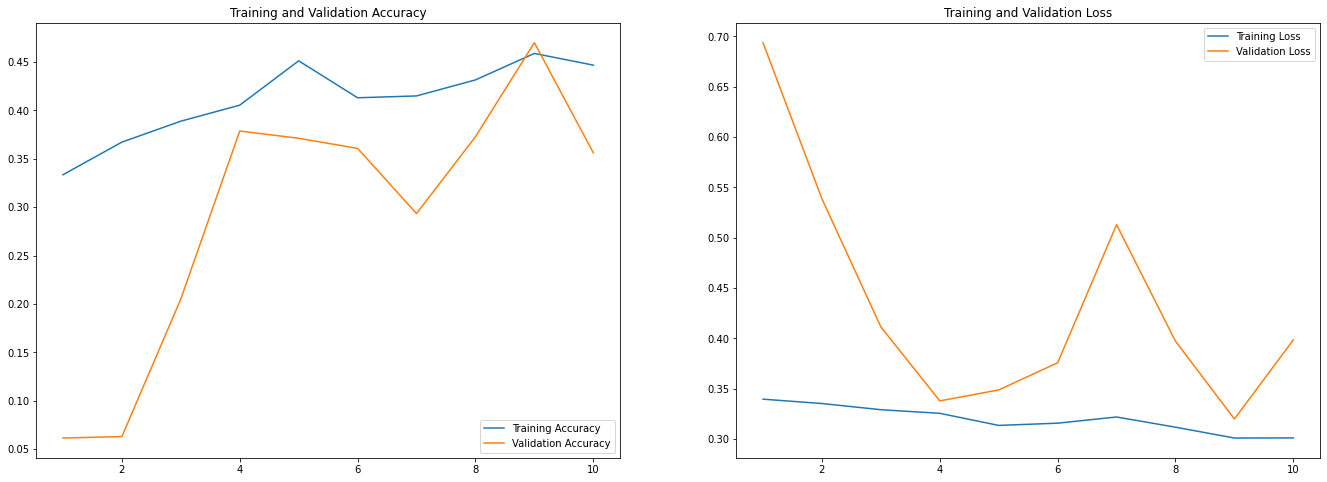

In [47]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

metrics = history.history['accuracy']
epochs_range = range(1, len(metrics) + 1) 

plt.figure(figsize=(23, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
#Evaluate on TEst

In [48]:
print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model_ResNet50.predict(test_images_ds)

Computing predictions...


In [49]:
probabilities.shape

(118, 9)

In [50]:
probabilities[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 1.], dtype=float32)

In [51]:
probabilities[0,:].shape

(9,)

In [52]:
test_ds.class_names

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

In [53]:
probabilities[:,4] 

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
      dtype=float32)

In [54]:
probabilities[:,4].shape

(118,)

In [55]:
#Submit predictions


In [56]:
file_paths = test_ds.file_paths

k = 1
while k<20:
    print(file_paths[k])
    k += 1

gdrive/My Drive/Test/pigmented benign keratosis/ISIC_0024408.jpg
gdrive/My Drive/Test/melanoma/ISIC_0000035.jpg
gdrive/My Drive/Test/pigmented benign keratosis/ISIC_0024358.jpg
gdrive/My Drive/Test/basal cell carcinoma/ISIC_0024454.jpg
gdrive/My Drive/Test/vascular lesion/ISIC_0024402.jpg
gdrive/My Drive/Test/melanoma/ISIC_0000056.jpg
gdrive/My Drive/Test/pigmented benign keratosis/ISIC_0024381.jpg
gdrive/My Drive/Test/pigmented benign keratosis/ISIC_0024422.jpg
gdrive/My Drive/Test/dermatofibroma/ISIC_0001130.jpg
gdrive/My Drive/Test/melanoma/ISIC_0000029.jpg
gdrive/My Drive/Test/actinic keratosis/ISIC_0024763.jpg
gdrive/My Drive/Test/actinic keratosis/ISIC_0024646.jpg
gdrive/My Drive/Test/actinic keratosis/ISIC_0010512.jpg
gdrive/My Drive/Test/actinic keratosis/ISIC_0025368.jpg
gdrive/My Drive/Test/dermatofibroma/ISIC_0024973.jpg
gdrive/My Drive/Test/melanoma/ISIC_0000022.jpg
gdrive/My Drive/Test/squamous cell carcinoma/ISIC_0012079.jpg
gdrive/My Drive/Test/nevus/ISIC_0000009.jpg
gdr

In [57]:
file_paths[1].split(os.sep)[-1]

'ISIC_0024408.jpg'

In [58]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(img_count_test))).numpy().astype('U')

img_list = []
img_id_list = []
img_name_list = []
for i in range(len(file_paths)):
    img_list.append(file_paths[i].split(os.sep)[-1])
    img_id_list.append(i)
    img_name_list.append(file_paths[i].split(os.sep)[-1][0:-4])

img_name_list_by_test_ids = []
for iid in list(test_ids):
    print(int(iid),img_name_list[int(iid)],probabilities[:,4][int(iid)]) # here dummy iid got str not int, thus converted
    img_name_list_by_test_ids.append(img_name_list[int(iid)])

Generating submission.csv file...
3 ISIC_0024358 0.0
1 ISIC_0024408 0.0
5 ISIC_0024402 0.0
0 ISIC_0024511 0.0
1 ISIC_0024408 0.0
0 ISIC_0024511 0.0
4 ISIC_0024454 0.0
7 ISIC_0024381 0.0
0 ISIC_0024511 0.0
5 ISIC_0024402 0.0
5 ISIC_0024402 0.0
2 ISIC_0000035 0.0
7 ISIC_0024381 0.0
5 ISIC_0024402 0.0
6 ISIC_0000056 0.0
1 ISIC_0024408 0.0
7 ISIC_0024381 0.0
2 ISIC_0000035 0.0
3 ISIC_0024358 0.0
4 ISIC_0024454 0.0
1 ISIC_0024408 0.0
4 ISIC_0024454 0.0
7 ISIC_0024381 0.0
8 ISIC_0024422 0.0
7 ISIC_0024381 0.0
3 ISIC_0024358 0.0
1 ISIC_0024408 0.0
3 ISIC_0024358 0.0
1 ISIC_0024408 0.0
1 ISIC_0024408 0.0
1 ISIC_0024408 0.0
4 ISIC_0024454 0.0
1 ISIC_0024408 0.0
8 ISIC_0024422 0.0
0 ISIC_0024511 0.0
4 ISIC_0024454 0.0
3 ISIC_0024358 0.0
5 ISIC_0024402 0.0
0 ISIC_0024511 0.0
5 ISIC_0024402 0.0
1 ISIC_0024408 0.0
3 ISIC_0024358 0.0
3 ISIC_0024358 0.0
6 ISIC_0000056 0.0
1 ISIC_0024408 0.0
7 ISIC_0024381 0.0
1 ISIC_0024408 0.0
5 ISIC_0024402 0.0
3 ISIC_0024358 0.0
3 ISIC_0024358 0.0
1 ISIC_0024408 0

In [59]:
#pred_df = pd.DataFrame({'image_name': img_name_list_by_test_ids, 'target': probabilities[:,1]}) # 'ids':test_ids
pred_df = pd.DataFrame({'image_name': img_name_list, 'target': probabilities[:,4]}) # 'ids':test_ids
pred_df.head()

,image_name,target
0,ISIC_0024511,0.0
1,ISIC_0024408,0.0
2,ISIC_0000035,0.0
3,ISIC_0024358,0.0
4,ISIC_0024454,0.0


In [60]:
pred_df['target'].unique()

array([0.], dtype=float32)